In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 特徵選擇
-降維 以方便可視化與解釋
---

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("atharvasoundankar/ai-developer-productivity-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\atharvasoundankar\ai-developer-productivity-dataset\versions\1


In [11]:
import os
for file in os.listdir(path):
    if file.endswith(".csv"):
        print("Found CSV file:", file)
        # Load the dataset
        PATH = os.path.join(path, file)
        dataset = pd.read_csv(PATH)

dataset.head()

Found CSV file: ai_dev_productivity.csv


,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
0,5.99,600,1,5.8,2,1,0.71,5.4,1
1,4.72,568,2,6.9,5,3,1.75,4.7,1
2,6.30,560,1,8.9,2,0,2.27,2.2,1
3,8.05,600,7,6.3,9,5,1.40,5.9,0
4,4.53,421,6,6.9,4,0,1.26,6.3,1


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hours_coding      500 non-null    float64
 1   coffee_intake_mg  500 non-null    int64  
 2   distractions      500 non-null    int64  
 3   sleep_hours       500 non-null    float64
 4   commits           500 non-null    int64  
 5   bugs_reported     500 non-null    int64  
 6   ai_usage_hours    500 non-null    float64
 7   cognitive_load    500 non-null    float64
 8   task_success      500 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


In [13]:
X_default = dataset.drop(columns=["task_success"])
y_default = dataset["task_success"]

# 創建pipline

演算法由於 資料(500 samples)數量不算多；隨機森林樹

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import (
                                        SequentialFeatureSelector as SFS , 
                                        RFECV )
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_default, y_default, test_size=0.2, random_state=42)

pipeline = make_pipeline(StandardScaler(),
                         SFS(
                             estimator=SVC(),
                             n_features_to_select=2,
                             scoring="accuracy",
                             cv=5,
                             n_jobs=-1
                         ),
                         RandomForestClassifier(random_state=42)
                )

使用網格搜尋-最佳超參數
---

In [15]:
RandomForestClassifier_params = {
    "randomforestclassifier__n_estimators": [i for i in range(50, 250, 25)],
    "randomforestclassifier__max_depth": [None, 10, 20, 30],
    "randomforestclassifier__criterion": ["gini", "entropy"]
}
G_CV = GridSearchCV(
    estimator=pipeline,
    param_grid=RandomForestClassifier_params,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

In [16]:
G_CV.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sequentialfeatureselector',
                                        SequentialFeatureSelector(estimator=SVC(),
                                                                  n_features_to_select=2,
                                                                  n_jobs=-1,
                                                                  scoring='accuracy')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [None, 10, 20,
                                                               30],
                         'randomforestclassifier__n_estimators': [50, 75, 100,
                                                                  125, 150, 175,
                                                                  200, 225]},
             scoring='accuracy', verbose=1)

最佳超參數 與 分數
---

In [17]:

print("Best parameters found: ", G_CV.best_params_)
print("Best score: ", G_CV.best_score_)

Best parameters found:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 150}
Best score:  0.9825000000000002


TOP-2 重要特徵
---

In [18]:
selected_features = X_train.columns[G_CV.best_estimator_.named_steps["sequentialfeatureselector"].get_support()]    
print("Selected features: ", selected_features)

Selected features:  Index(['hours_coding', 'cognitive_load'], dtype='object')


# 

In [19]:
from sklearn.metrics import classification_report

y_pred = G_CV.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.98      0.98      0.98        66

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



<Axes: xlabel='hours_coding', ylabel='cognitive_load'>

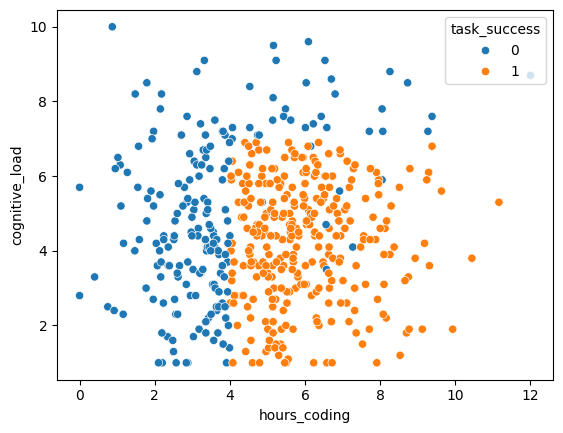

In [20]:
sns.scatterplot(data=dataset,
                x = "hours_coding",
                y = "cognitive_load",
                hue = "task_success")

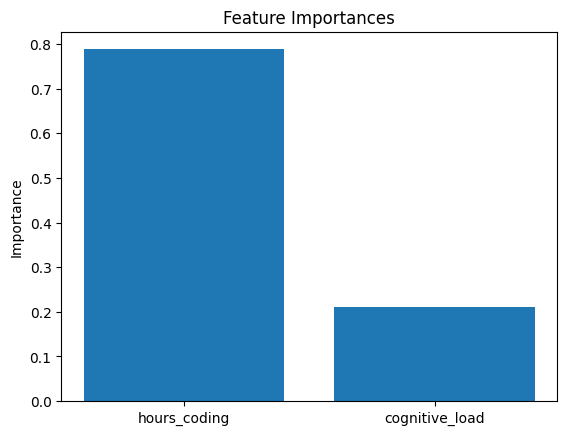

In [21]:
import matplotlib.pyplot as plt

model = G_CV.best_estimator_.named_steps["randomforestclassifier"]
importances = model.feature_importances_

# 繪圖
plt.bar(selected_features, importances)
plt.title("Feature Importances")
plt.ylabel("Importance")
plt.show()
